# Data Mining Techniques - Project 2

Eleftheria Vrachoriti

Start by importing all the libraries that we are going to use later.

In [1]:
import pandas as pd
import datetime
import sys
import ast
import re

import os
import csv
import time
import urllib.request
import glob

from unicodedata import category

from wordcloud import WordCloud
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from gensim.models import Word2Vec

from scipy.spatial.distance import cosine
from scipy.sparse import *
import numpy as np

import seaborn as sns
import cv2

import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Mount our drive in order to load the .csv file.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Question 1 - Data preprocessing/cleaning

Load the .csv file, create a data frame for our data and print the first 5 rows.

In [2]:
df = pd.read_csv('/content/drive/MyDrive/books_1.Best_Books_Ever.csv')
df.head()

,bookId,title,series,author,rating,description,language,isbn,genres,characters,...,firstPublishDate,awards,numRatings,ratingsByStars,likedPercent,setting,coverImg,bbeScore,bbeVotes,price
0,2767052-the-hunger-games,The Hunger Games,The Hunger Games #1,Suzanne Collins,4.33,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,English,9780439023481,"['Young Adult', 'Fiction', 'Dystopia', 'Fantas...","['Katniss Everdeen', 'Peeta Mellark', 'Cato (H...",...,NaN,['Locus Award Nominee for Best Young Adult Boo...,6376780,"['3444695', '1921313', '745221', '171994', '93...",96.0,"['District 12, Panem', 'Capitol, Panem', 'Pane...",https://i.gr-assets.com/images/S/compressed.ph...,2993816,30516,5.09
1,2.Harry_Potter_and_the_Order_of_the_Phoenix,Harry Potter and the Order of the Phoenix,Harry Potter #5,"J.K. Rowling, Mary GrandPré (Illustrator)",4.50,There is a door at the end of a silent corrido...,English,9780439358071,"['Fantasy', 'Young Adult', 'Fiction', 'Magic',...","['Sirius Black', 'Draco Malfoy', 'Ron Weasley'...",...,06/21/03,['Bram Stoker Award for Works for Young Reader...,2507623,"['1593642', '637516', '222366', '39573', '14526']",98.0,['Hogwarts School of Witchcraft and Wizardry (...,https://i.gr-assets.com/images/S/compressed.ph...,2632233,26923,7.38
2,2657.To_Kill_a_Mockingbird,To Kill a Mockingbird,To Kill a Mockingbird,Harper Lee,4.28,The unforgettable novel of a childhood in a sl...,English,9999999999999,"['Classics', 'Fiction', 'Historical Fiction', ...","['Scout Finch', 'Atticus Finch', 'Jem Finch', ...",...,07/11/60,"['Pulitzer Prize for Fiction (1961)', 'Audie A...",4501075,"['2363896', '1333153', '573280', '149952', '80...",95.0,"['Maycomb, Alabama (United States)']",https://i.gr-assets.com/images/S/compressed.ph...,2269402,23328,NaN
3,1885.Pride_and_Prejudice,Pride and Prejudice,NaN,"Jane Austen, Anna Quindlen (Introduction)",4.26,Alternate cover edition of ISBN 9780679783268S...,English,9999999999999,"['Classics', 'Fiction', 'Romance', 'Historical...","['Mr. Bennet', 'Mrs. Bennet', 'Jane Bennet', '...",...,01/28/13,[],2998241,"['1617567', '816659', '373311', '113934', '767...",94.0,"['United Kingdom', 'Derbyshire, England (Unite...",https://i.gr-assets.com/images/S/compressed.ph...,1983116,20452,NaN
4,41865.Twilight,Twilight,The Twilight Saga #1,Stephenie Meyer,3.60,About three things I was absolutely positive.\...,English,9780316015844,"['Young Adult', 'Fantasy', 'Romance', 'Vampire...","['Edward Cullen', 'Jacob Black', 'Laurent', 'R...",...,10/05/05,"['Georgia Peach Book Award (2007)', 'Buxtehude...",4964519,"['1751460', '1113682', '1008686', '542017', '5...",78.0,"['Forks, Washington (United States)', 'Phoenix...",https://i.gr-assets.com/images/S/compressed.ph...,1459448,14874,2.1


## Check for duplicates

### <code>bookId</code> column

Book ids should be unique for each book.

In [3]:
df['bookId'].describe()

count                 52478
unique                52424
top       650584.Shadowdale
freq                      2
Name: bookId, dtype: object

Results from the previous cell show that $57$ books have a duplicate id.

Remove duplicates from the dataset (keep the rows that have the first appearance of the duplicate ids).

In [4]:
df.drop_duplicates(subset=['bookId'], keep='first', inplace=True)

Verify changes made above.

In [5]:
df['bookId'].describe()

count                        52424
unique                       52424
top       2767052-the-hunger-games
freq                             1
Name: bookId, dtype: object

Now all books have unique ids.

## Check for invalid values

### <code>isbn</code> column

In [6]:
df['isbn'].describe()

count             52424
unique            48072
top       9999999999999
freq               4350
Name: isbn, dtype: object

There are $4350$ books with <code>ISBN:9999999999999</code>

Search for these entries and drop respective rows from the dataset.

In [7]:
is_invalid_isbn = df['isbn'] == '9999999999999'
invalid_isbn = df[is_invalid_isbn]
invalid_isbn_row_indices = list(invalid_isbn.index)
df = df.drop(invalid_isbn_row_indices)

Verify changes made above.

In [8]:
df['isbn'].describe()

count             48074
unique            48071
top       9780765326355
freq                  2
Name: isbn, dtype: object

We can verify that $4350$ rows were removed.

Results from the previous cell show that $3$ books have a duplicate ISBN.

Remove duplicates from the dataset (keep the rows that have the first appearance of the duplicate ids).

In [9]:
df.drop_duplicates(subset=['isbn'], keep='first', inplace=True)

Verify changes made above.

In [10]:
df['isbn'].describe()

count             48071
unique            48071
top       9780439023481
freq                  1
Name: isbn, dtype: object

Now all books have unique ISBNs.

## Check for null values

Obtain the number of non-null values per column.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48071 entries, 0 to 52477
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bookId            48071 non-null  object 
 1   title             48071 non-null  object 
 2   series            21596 non-null  object 
 3   author            48071 non-null  object 
 4   rating            48071 non-null  float64
 5   description       47154 non-null  object 
 6   language          44700 non-null  object 
 7   isbn              48071 non-null  object 
 8   genres            48071 non-null  object 
 9   characters        48071 non-null  object 
 10  bookFormat        47378 non-null  object 
 11  edition           4252 non-null   object 
 12  pages             46477 non-null  object 
 13  publisher         45595 non-null  object 
 14  publishDate       47547 non-null  object 
 15  firstPublishDate  29040 non-null  object 
 16  awards            48071 non-null  object

### <code>description</code> column

Results from the previous cells show that $917$ books don't have a description.

Search for null entries and drop respective rows from the dataset.

In [12]:
is_nan_description = df['description'].isnull()
nan_description_rows = df[is_nan_description]
nan_description_row_indices = list(nan_description_rows.index)
df = df.drop(nan_description_row_indices)

Verify changes made above by printing the result of <code>df.info()</code> again.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47154 entries, 0 to 52477
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bookId            47154 non-null  object 
 1   title             47154 non-null  object 
 2   series            21454 non-null  object 
 3   author            47154 non-null  object 
 4   rating            47154 non-null  float64
 5   description       47154 non-null  object 
 6   language          44026 non-null  object 
 7   isbn              47154 non-null  object 
 8   genres            47154 non-null  object 
 9   characters        47154 non-null  object 
 10  bookFormat        46585 non-null  object 
 11  edition           4199 non-null   object 
 12  pages             45744 non-null  object 
 13  publisher         44804 non-null  object 
 14  publishDate       46704 non-null  object 
 15  firstPublishDate  28650 non-null  object 
 16  awards            47154 non-null  object

Now all entries of <code>description</code> column are non-null.

### <code>language</code> column

There are $3128$ books with no language specified.

In [14]:
is_nan_language = df['language'].isnull()
nan_language = df[is_nan_language]
nan_language_row_indices = list(nan_language.index)
df = df.drop(nan_language_row_indices)

Verify changes made above.

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44026 entries, 0 to 52477
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bookId            44026 non-null  object 
 1   title             44026 non-null  object 
 2   series            20538 non-null  object 
 3   author            44026 non-null  object 
 4   rating            44026 non-null  float64
 5   description       44026 non-null  object 
 6   language          44026 non-null  object 
 7   isbn              44026 non-null  object 
 8   genres            44026 non-null  object 
 9   characters        44026 non-null  object 
 10  bookFormat        43646 non-null  object 
 11  edition           4139 non-null   object 
 12  pages             43036 non-null  object 
 13  publisher         42190 non-null  object 
 14  publishDate       43730 non-null  object 
 15  firstPublishDate  27245 non-null  object 
 16  awards            44026 non-null  object

### <code>publisher</code> column

Results from the previous cells show that there are $1836$ books with no publisher specified.

Search for null entries and drop respective rows from the dataset.

In [16]:
is_nan_publisher = df['publisher'].isnull()
nan_publisher = df[is_nan_publisher]
nan_publisher_row_indices = list(nan_publisher.index)
df = df.drop(nan_publisher_row_indices)

Verify changes made above.

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42190 entries, 0 to 52477
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bookId            42190 non-null  object 
 1   title             42190 non-null  object 
 2   series            19509 non-null  object 
 3   author            42190 non-null  object 
 4   rating            42190 non-null  float64
 5   description       42190 non-null  object 
 6   language          42190 non-null  object 
 7   isbn              42190 non-null  object 
 8   genres            42190 non-null  object 
 9   characters        42190 non-null  object 
 10  bookFormat        41958 non-null  object 
 11  edition           4027 non-null   object 
 12  pages             41440 non-null  object 
 13  publisher         42190 non-null  object 
 14  publishDate       42190 non-null  object 
 15  firstPublishDate  26507 non-null  object 
 16  awards            42190 non-null  object

### <code>bookFormat</code> column

Results from the previous cells show that there are $232$ books with no book format specified.

Search for null entries and drop respective rows from the dataset.

In [18]:
is_nan_book_format = df['bookFormat'].isnull()
nan_book_format = df[is_nan_book_format]
nan_book_format_row_indices = list(nan_book_format.index)
df = df.drop(nan_book_format_row_indices)

Verify changes made above.

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41958 entries, 0 to 52477
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bookId            41958 non-null  object 
 1   title             41958 non-null  object 
 2   series            19447 non-null  object 
 3   author            41958 non-null  object 
 4   rating            41958 non-null  float64
 5   description       41958 non-null  object 
 6   language          41958 non-null  object 
 7   isbn              41958 non-null  object 
 8   genres            41958 non-null  object 
 9   characters        41958 non-null  object 
 10  bookFormat        41958 non-null  object 
 11  edition           4013 non-null   object 
 12  pages             41211 non-null  object 
 13  publisher         41958 non-null  object 
 14  publishDate       41958 non-null  object 
 15  firstPublishDate  26362 non-null  object 
 16  awards            41958 non-null  object

### <code>likedPercent</code> column

Results from the previous cells show that there are $241$ books with no liked percent specified.

Search for null entries and drop respective rows from the dataset.

In [20]:
has_liked_percent = df['likedPercent'].isnull()
liked_percent = df[has_liked_percent]
liked_percent_row_indices = list(liked_percent.index)
df = df.drop(liked_percent_row_indices)

Verify changes made above.

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41717 entries, 0 to 52477
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bookId            41717 non-null  object 
 1   title             41717 non-null  object 
 2   series            19425 non-null  object 
 3   author            41717 non-null  object 
 4   rating            41717 non-null  float64
 5   description       41717 non-null  object 
 6   language          41717 non-null  object 
 7   isbn              41717 non-null  object 
 8   genres            41717 non-null  object 
 9   characters        41717 non-null  object 
 10  bookFormat        41717 non-null  object 
 11  edition           3995 non-null   object 
 12  pages             40997 non-null  object 
 13  publisher         41717 non-null  object 
 14  publishDate       41717 non-null  object 
 15  firstPublishDate  26301 non-null  object 
 16  awards            41717 non-null  object

### <code>pages</code> column

Results from the previous cells show that there are $241$ books with no  given number of pages.

Search for null entries and drop respective rows from the dataset.

In [22]:
has_pages = df['pages'].isnull()
pages = df[has_pages]
pages_row_indices = list(pages.index)
df = df.drop(pages_row_indices)

Verify changes made above.

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40997 entries, 0 to 52477
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bookId            40997 non-null  object 
 1   title             40997 non-null  object 
 2   series            19093 non-null  object 
 3   author            40997 non-null  object 
 4   rating            40997 non-null  float64
 5   description       40997 non-null  object 
 6   language          40997 non-null  object 
 7   isbn              40997 non-null  object 
 8   genres            40997 non-null  object 
 9   characters        40997 non-null  object 
 10  bookFormat        40997 non-null  object 
 11  edition           3914 non-null   object 
 12  pages             40997 non-null  object 
 13  publisher         40997 non-null  object 
 14  publishDate       40997 non-null  object 
 15  firstPublishDate  25923 non-null  object 
 16  awards            40997 non-null  object

### <code>firstPublishDate</code> column

Results from the previous cells show that for $15074$ books the first publish date hasn't been recorded.

Search for null entries and drop respective rows from the dataset.

In [24]:
has_first_publish_date = df['firstPublishDate'].isnull()
first_publish_date = df[has_first_publish_date]
first_publish_date_row_indices = list(first_publish_date.index)
df = df.drop(first_publish_date_row_indices)

Verify changes made above.

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25923 entries, 1 to 52476
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bookId            25923 non-null  object 
 1   title             25923 non-null  object 
 2   series            11168 non-null  object 
 3   author            25923 non-null  object 
 4   rating            25923 non-null  float64
 5   description       25923 non-null  object 
 6   language          25923 non-null  object 
 7   isbn              25923 non-null  object 
 8   genres            25923 non-null  object 
 9   characters        25923 non-null  object 
 10  bookFormat        25923 non-null  object 
 11  edition           2464 non-null   object 
 12  pages             25923 non-null  object 
 13  publisher         25923 non-null  object 
 14  publishDate       25923 non-null  object 
 15  firstPublishDate  25923 non-null  object 
 16  awards            25923 non-null  object

### <code>price</code> column

Results from the previous cells show that there are $2678$ books don't have a price.

Search for null entries and drop respective rows from the dataset.

In [26]:
is_price = df['price'].isnull()
price = df[is_price]
price_row_indices = list(price.index)
df = df.drop(price_row_indices)

Verify changes made above.

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23245 entries, 1 to 52476
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bookId            23245 non-null  object 
 1   title             23245 non-null  object 
 2   series            9876 non-null   object 
 3   author            23245 non-null  object 
 4   rating            23245 non-null  float64
 5   description       23245 non-null  object 
 6   language          23245 non-null  object 
 7   isbn              23245 non-null  object 
 8   genres            23245 non-null  object 
 9   characters        23245 non-null  object 
 10  bookFormat        23245 non-null  object 
 11  edition           2041 non-null   object 
 12  pages             23245 non-null  object 
 13  publisher         23245 non-null  object 
 14  publishDate       23245 non-null  object 
 15  firstPublishDate  23245 non-null  object 
 16  awards            23245 non-null  object

### <code>coverImg</code> column

Results from the previous cells show that there are $40$ books with no url to their cover image.

Search for null entries and drop respective rows from the dataset.

In [28]:
has_cover_img = df['coverImg'].isnull()
cover_img = df[has_cover_img]
cover_img_row_indices = list(cover_img.index)
df = df.drop(cover_img_row_indices)

Verify changes made above.

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23205 entries, 1 to 52476
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bookId            23205 non-null  object 
 1   title             23205 non-null  object 
 2   series            9870 non-null   object 
 3   author            23205 non-null  object 
 4   rating            23205 non-null  float64
 5   description       23205 non-null  object 
 6   language          23205 non-null  object 
 7   isbn              23205 non-null  object 
 8   genres            23205 non-null  object 
 9   characters        23205 non-null  object 
 10  bookFormat        23205 non-null  object 
 11  edition           2039 non-null   object 
 12  pages             23205 non-null  object 
 13  publisher         23205 non-null  object 
 14  publishDate       23205 non-null  object 
 15  firstPublishDate  23205 non-null  object 
 16  awards            23205 non-null  object

### <code>ratingsByStars</code> column

Print a description of this column's entries.

In [30]:
df['ratingsByStars'].describe()

count     23205
unique    23138
top          []
freq         45
Name: ratingsByStars, dtype: object

As we can see, there are $732$ books with no ratings.

Search for null entries and drop respective rows from the dataset.

In [31]:
# values are stored as strings inside the dataframe
is_nan_ratings_by_stars = df['ratingsByStars'] == '[]'
nan_ratings_by_stars = df[is_nan_ratings_by_stars]
nan_ratings_by_stars_row_indices = list(nan_ratings_by_stars.index)
df = df.drop(nan_ratings_by_stars_row_indices)

Verify changes made above.

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23160 entries, 1 to 52476
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bookId            23160 non-null  object 
 1   title             23160 non-null  object 
 2   series            9864 non-null   object 
 3   author            23160 non-null  object 
 4   rating            23160 non-null  float64
 5   description       23160 non-null  object 
 6   language          23160 non-null  object 
 7   isbn              23160 non-null  object 
 8   genres            23160 non-null  object 
 9   characters        23160 non-null  object 
 10  bookFormat        23160 non-null  object 
 11  edition           2035 non-null   object 
 12  pages             23160 non-null  object 
 13  publisher         23160 non-null  object 
 14  publishDate       23160 non-null  object 
 15  firstPublishDate  23160 non-null  object 
 16  awards            23160 non-null  object

Divide the contents of <code>ratingsByStars</code> column into $5$ columns:

 <code>ratingStar5</code>, <code>ratingStar4</code>, <code>ratingStar3</code>, <code>ratingStar2</code> and <code>ratingStar1</code>.

In [33]:
new_columns = ['ratingStar5', 'ratingStar4', 'ratingStar3', 'ratingStar2', 'ratingStar1']

df['ratingsByStars'] = df['ratingsByStars'].astype(str).apply(ast.literal_eval) # convert strings of type "['1', '2', ...]" to lists

for i, column in enumerate(new_columns):
  df[column] = df.apply(lambda row: int(row['ratingsByStars'][i]), axis = 1)

Verify changes made above.

In [34]:
columns = ['ratingsByStars'] + new_columns
df[columns].head()

,ratingsByStars,ratingStar5,ratingStar4,ratingStar3,ratingStar2,ratingStar1
1,"[1593642, 637516, 222366, 39573, 14526]",1593642,637516,222366,39573,14526
4,"[1751460, 1113682, 1008686, 542017, 548674]",1751460,1113682,1008686,542017,548674
5,"[1048230, 524674, 186297, 48864, 26211]",1048230,524674,186297,48864,26211
6,"[986764, 958699, 545475, 165093, 84682]",986764,958699,545475,165093,84682
8,"[78217, 22857, 6628, 1477, 967]",78217,22857,6628,1477,967


### <code>genres</code> column

Print a description of this column's entries.

In [35]:
df['genres'].describe()

count     23160
unique    22123
top          []
freq        324
Name: genres, dtype: object

As we can see, there are $1996$ books with no genre information.

Search for null entries and drop respective rows from the dataset.

In [36]:
# values are stored as strings inside the dataframe
is_nan_genres = df['genres'] == '[]'
nan_genres = df[is_nan_genres]
nan_genres_row_indices = list(nan_genres.index)
df = df.drop(nan_genres_row_indices)

Verify changes made above.

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22836 entries, 1 to 52476
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bookId            22836 non-null  object 
 1   title             22836 non-null  object 
 2   series            9810 non-null   object 
 3   author            22836 non-null  object 
 4   rating            22836 non-null  float64
 5   description       22836 non-null  object 
 6   language          22836 non-null  object 
 7   isbn              22836 non-null  object 
 8   genres            22836 non-null  object 
 9   characters        22836 non-null  object 
 10  bookFormat        22836 non-null  object 
 11  edition           1987 non-null   object 
 12  pages             22836 non-null  object 
 13  publisher         22836 non-null  object 
 14  publishDate       22836 non-null  object 
 15  firstPublishDate  22836 non-null  object 
 16  awards            22836 non-null  object

Keep only the first item of list of genres for each row.

In [38]:
df['genres'] = df['genres'].astype(str).apply(ast.literal_eval) # convert strings of type "['1', '2', ...]" to lists
df['genreSingle'] = df.apply(lambda row: row['genres'][0], axis=1)

Verify changes made above.

In [39]:
df['genreSingle'].head()

1               Fantasy
4           Young Adult
5    Historical Fiction
6              Classics
8               Fantasy
Name: genres, dtype: object

### <code>publishDate</code> column



In [40]:
df['publishDate'].describe()

count         22836
unique         6686
top       Published
freq             71
Name: publishDate, dtype: object

There are:
+ $246$ books with no publish date available.
+ $203$ books with the value <code>'Published'</code>

Search for null and invalid entries and drop respective rows from the dataset.

In [41]:
is_nan_publish_date = df['publishDate'].isnull()
nan_publish_date = df[is_nan_publish_date]
nan_publish_date_row_indices = list(nan_publish_date.index)
df = df.drop(nan_publish_date_row_indices)

In [42]:
is_inv_publish_date = df['publishDate'] == 'Published'
inv_publish_date = df[is_inv_publish_date]
inv_publish_date_row_indices = list(inv_publish_date.index)
df = df.drop(inv_publish_date_row_indices)

Verify changes made above.

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22765 entries, 1 to 52476
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bookId            22765 non-null  object 
 1   title             22765 non-null  object 
 2   series            9789 non-null   object 
 3   author            22765 non-null  object 
 4   rating            22765 non-null  float64
 5   description       22765 non-null  object 
 6   language          22765 non-null  object 
 7   isbn              22765 non-null  object 
 8   genres            22765 non-null  object 
 9   characters        22765 non-null  object 
 10  bookFormat        22765 non-null  object 
 11  edition           1980 non-null   object 
 12  pages             22765 non-null  object 
 13  publisher         22765 non-null  object 
 14  publishDate       22765 non-null  object 
 15  firstPublishDate  22765 non-null  object 
 16  awards            22765 non-null  object

In [44]:
df['publishDate'].head()

1    09/28/04
4    09/06/06
5    03/14/06
6    04/28/96
8    09/25/12
Name: publishDate, dtype: object

Match entries <code>publishDate</code> column to data type string formats and discard invalid entries.

In [45]:
df['publishDate'] = pd.to_datetime(df['publishDate'], errors='coerce', infer_datetime_format=True)

is_nan_publish_date = df['publishDate'].isnull()
nan_publish_date = df[is_nan_publish_date]
nan_publish_date_row_indices = list(nan_publish_date.index)
df = df.drop(nan_publish_date_row_indices)

df['publishDate'] = df.apply(lambda row: row['publishDate'].year, axis=1)

Verify changes made above.

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22764 entries, 1 to 52476
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bookId            22764 non-null  object 
 1   title             22764 non-null  object 
 2   series            9789 non-null   object 
 3   author            22764 non-null  object 
 4   rating            22764 non-null  float64
 5   description       22764 non-null  object 
 6   language          22764 non-null  object 
 7   isbn              22764 non-null  object 
 8   genres            22764 non-null  object 
 9   characters        22764 non-null  object 
 10  bookFormat        22764 non-null  object 
 11  edition           1979 non-null   object 
 12  pages             22764 non-null  object 
 13  publisher         22764 non-null  object 
 14  publishDate       22764 non-null  int64  
 15  firstPublishDate  22764 non-null  object 
 16  awards            22764 non-null  object

In [47]:
df['publishDate'].head()

1    2004
4    2006
5    2006
6    1996
8    2012
Name: publishDate, dtype: int64

# Question 2 - Plots

### Top 10 books with the most 5-star ratings

Find books with over $10000$ ratings first, then sort them in descending order according to the number of $5$-star ratings.

In [ ]:
columns = ['title', 'ratingStar5']

temp_df = pd.DataFrame()
has_over_10k = df['ratingStar5'] > 10000
temp_df = df[has_over_10k]
temp_df = temp_df.sort_values('ratingStar5', ascending=False)

temp_df[columns].head(10)

,title,ratingStar5
93,Harry Potter and the Prisoner of Azkaban,1892635
4,Twilight,1751460
126,Harry Potter and the Chamber of Secrets,1608855
1,Harry Potter and the Order of the Phoenix,1593642
147,"The Hobbit, or There and Back Again",1527113
21,Divergent,1409189
46,A Game of Thrones,1231600
5,The Book Thief,1048230
42,The Lightning Thief,1006885
6,Animal Farm,986764


### Top 10 writers with the most books written

In [ ]:
temp_df = pd.DataFrame()
temp_df = df.groupby(['author'])['bookId'].count().reset_index()
temp_df = temp_df.sort_values('bookId', ascending=False)

temp_df.head(10)

,author,bookId
120,Agatha Christie,64
12303,Terry Pratchett,41
9647,Nora Roberts (Goodreads Author),39
3574,Enid Blyton,38
7032,Karen Kingsbury (Goodreads Author),34
2827,Dean Koontz (Goodreads Author),34
11854,Stephen King (Goodreads Author),33
9795,P.G. Wodehouse,33
9740,Orson Scott Card,33
10285,Piers Anthony,31


### Top 10 writers with the most ratings

In [ ]:
temp_df = pd.DataFrame()
temp_df = df.groupby(['author'])['numRatings'].sum().reset_index()
temp_df = temp_df.sort_values('numRatings', ascending=False)

temp_df.head(10)

,author,numRatings
5330,"J.K. Rowling, Mary GrandPré (Illustrator)",8147550
11854,Stephen King (Goodreads Author),6231542
11884,Stephenie Meyer,6226590
4291,George R.R. Martin,4346390
5353,J.R.R. Tolkien,3697012
6548,John Steinbeck,3573481
120,Agatha Christie,3470052
2500,Dan Brown (Goodreads Author),3267282
5304,J.D. Salinger,3102429
12795,Veronica Roth (Goodreads Author),2912294


### Most frequent words found in book titles

The following functions tokenize, remove various symbols, convert text to lowercase, remove stopwords and lemmatize the contents of the given column of the given dataset.

The symbols and stopwords removed are from the <code>nltk</code> library

Single digits, as well single characters are also removed.
<br></br>

The three functions are part of the Natural Language Processing (NLP) pipeline and will be used in other sections as well.

In [ ]:
symbols_all = [chr(i) for i in range(sys.maxunicode + 1)]
symbols = [symbol for symbol in symbols_all if category(symbol).startswith("P")
                                                  or category(symbol).startswith("Sk")
                                                  or category(symbol).startswith("Sm")]

def remove_symbols(temp_df, column, symbols=symbols):
  processed_column = 'processed_' + column
  for i, symbol in enumerate(symbols):
    if i == 0:
      temp_df[processed_column] = temp_df.apply(lambda row: row[column].replace(symbol, ' '), axis=1)
      continue
    temp_df[processed_column] = temp_df.apply(lambda row: row[processed_column].replace(symbol, ' '), axis=1)
  temp_df[processed_column] = temp_df.apply(lambda row: row[processed_column].lower().split(), axis=1)

stop_words = stopwords.words('english')
characters = [char for char in 'abcdefghijklmnopqrstuvxyzABCDEFGHIJKLMNOPQRSTUVXYZ0123456789']
for char in characters:
  if char not in stop_words:
    stop_words.append(char)

def remove_stopwords(temp_df, column, stop_words=stop_words):
  processed_column = 'processed_' + column
  temp_df[processed_column] = temp_df.apply(lambda row: [word for word in row[processed_column] if word not in stop_words], axis=1)

def lemmatize(temp_df, column):
  processed_column   = 'processed_' + column
  lemmatizer = WordNetLemmatizer()
  temp_df[processed_column] = temp_df.apply(lambda row: [lemmatizer.lemmatize(lemmatizer.lemmatize(word, pos='v'), pos='n')
                                                            for word in row[processed_column]], axis=1)

Create a new dataframe to store books written in English.

In [ ]:
is_english = df['language'] == 'English'
english_df = pd.DataFrame()
english_df = df[is_english]

Copy <code>title</code> column to a new dataframe.

In [ ]:
temp_df = pd.DataFrame()
temp_df['title'] = english_df['title'].copy(deep=True)
temp_df.reset_index(drop=True, inplace=True)

Remove symbols, stopwords and lemmatize book titles.

In [ ]:
remove_symbols(temp_df, 'title')
remove_stopwords(temp_df, 'title')
lemmatize(temp_df, 'title')

The following functions can be used to produce a list of words in descending order of times appeared in the given column of the given dataframe.

In [ ]:
def word_count(temp_df, column):
  words = [] # words encountered
  times = [] # times encountered word
  for row in temp_df[column]:
    for word in row:
      if word not in words:
        words.append(word)
        times.append(1)
      else:
        for i in range(0, len(words)):
          if word == words[i]:
            times[i] += 1
            break
  return words, times

def k_most_frequent_words(temp_df, processed_column, k):
  words, times = word_count(temp_df, processed_column)
  times, words = (list(x) for x in zip(*sorted(zip(times, words), reverse=True)))
  return words[:k], times[:k]

For demonstration reasons, we show the 10 most frequent words found in book titles.

In [ ]:
k = 10
words, times = k_most_frequent_words(temp_df, 'processed_title', k)

temp_df = pd.DataFrame()
temp_df['words'] = pd.Series(words)
temp_df['times'] = pd.Series(times)
temp_df

,words,times
0,life,470
1,vol,444
2,story,351
3,world,342
4,love,318
5,man,299
6,stories,252
7,book,242
8,one,223
9,last,213


### Wordcloud of the most frequent words found in book descriptions.

Copy <code>description</code> column to a new dataframe.

In [ ]:
temp_df = pd.DataFrame()
temp_df['description'] = english_df['description'].copy(deep=True)
temp_df.reset_index(drop=True, inplace=True)

Remove symbols, stopwords and lemmatize book descriptions.

In [ ]:
remove_symbols(temp_df, 'description')
remove_stopwords(temp_df, 'description')
lemmatize(temp_df, 'description')

Demonstration of the changes made above for one book title.

In [ ]:
print("--- Original description")
print(temp_df['description'][0])
print()
print("--- Processed desciption")
print(temp_df['processed_description'][0])

--- Original description
There is a door at the end of a silent corridor. And it’s haunting Harry Pottter’s dreams. Why else would he be waking in the middle of the night, screaming in terror?Harry has a lot on his mind for this, his fifth year at Hogwarts: a Defense Against the Dark Arts teacher with a personality like poisoned honey; a big surprise on the Gryffindor Quidditch team; and the looming terror of the Ordinary Wizarding Level exams. But all these things pale next to the growing threat of He-Who-Must-Not-Be-Named - a threat that neither the magical government nor the authorities at Hogwarts can stop.As the grasp of darkness tightens, Harry must discover the true depth and strength of his friends, the importance of boundless loyalty, and the shocking price of unbearable sacrifice.His fate depends on them all.

--- Processed desciption
['door', 'end', 'silent', 'corridor', 'haunting', 'harry', 'pottter', 'dreams', 'else', 'would', 'waking', 'middle', 'night', 'screaming', 'ter

Wordcloud

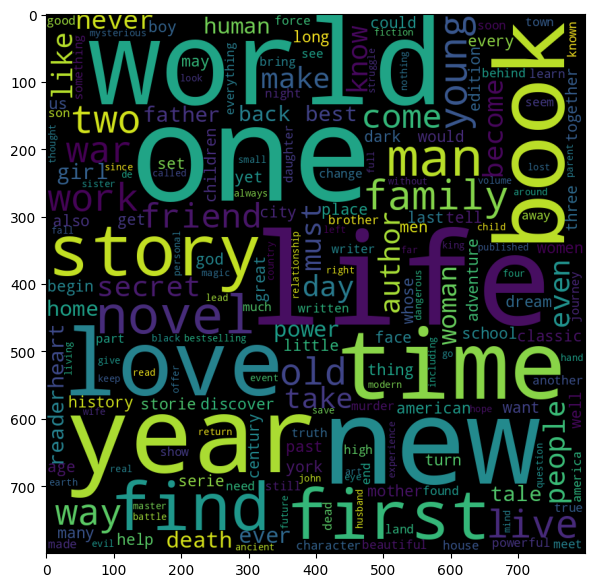

In [ ]:
temp_df['processed_description'] = temp_df.apply(lambda row: ' '.join([word for word in row['processed_description'] if word not in stop_words]), axis=1)

processed_description_list = ' '.join(temp_df['processed_description'].tolist())
word_cloud = WordCloud(width=800, height=800, max_font_size=200, min_font_size=10, stopwords=stop_words,
                       collocations=False).generate(processed_description_list)

plt.figure(figsize=(7, 7))
plt.imshow(word_cloud)
plt.show()

# Question 3 - Recommendation system

Create a new dataframe to store the books that have been written in english.

In [ ]:
temp_df = pd.DataFrame()
temp_df[['bookId', 'description']] = english_df[['bookId', 'description']].copy(deep=True)
temp_df.reset_index(drop=True, inplace=True)

Remove symbols, stopwords and lemmatize book descriptions.

Join words of description in order to pass the processed description to TF-IDF later.

In [ ]:
remove_symbols(temp_df, 'description')
remove_stopwords(temp_df, 'description')
temp_df['processed_description'] = temp_df.apply(lambda row: ' '.join([word for word in row['processed_description'] if word not in stop_words]), axis=1)

### TF-IDF with unigrams

Create a TF-IDF Vectorizer with unigrams and a maximum of $10000$ features (words/tokens) and fit it to the processed descriptions.

In [ ]:
%%time
tfidf_vectorizer_unigram = TfidfVectorizer(max_df=1.0, min_df=0, max_features=10000, ngram_range=(1, 1), stop_words='english')
tfidf_unigram = tfidf_vectorizer_unigram.fit_transform(temp_df['description'])
tfidf_unigram = tfidf_unigram.toarray()

CPU times: user 3.32 s, sys: 1.9 s, total: 5.22 s
Wall time: 5.32 s


Calculate the cosine similarity matrix.

In [ ]:
%%time
cosine_similarity_matrix = cosine_similarity(tfidf_unigram)

CPU times: user 3min 28s, sys: 4.12 s, total: 3min 32s
Wall time: 2min 4s


Load (if already calculated) or save the cosine similarity matrix.

In [ ]:
with open('/content/drive/MyDrive/cosine_unigram_sklearn_10k.pkl', 'rb') as f:
  cosine_similarity_matrix = pickle.load(f)

In [ ]:
with open('/content/drive/MyDrive/cosine_unigram_sklearn_10k.pkl', 'wb') as f:
  pickle.dump(cosine_similarity_matrix, f)

Find the $100$ books that are the most similar to each book based on their cosine similarity score and store them in a dictionary.

In [ ]:
%%time
k = 100
similar_books = {}
rows = len(temp_df['bookId'].tolist())
for i in range(0, rows):
  similar_books[temp_df['bookId'][i]] = [(temp_df['bookId'][book[0]], cosine_similarity_matrix[i][book[0]])
                                        for book in sorted(list(enumerate(cosine_similarity_matrix[i])),
                                                           key=lambda x:x[1], reverse=True)[:(k + 1)] if book[0] != i]

CPU times: user 5min 53s, sys: 746 ms, total: 5min 54s
Wall time: 5min 58s


The following function prints the title and description of the $k$ books that are most similar to the book with the given id, based on the given dictionary.

In [ ]:
def recommend(dictionary, book_id, k):
  book = english_df.loc[english_df['bookId'] == book_id]
  if book.empty:
    print('Book id not found')
    return
  index = book.index[0]
  book_list = dictionary[book_id]
  print('Recommending', k, 'books similar to:', english_df['title'][index])
  print("------------------------------------------------------------------")
  for i in range(0, k):
    id, score = book_list[i] # id and score of the recommended book
    recommended_book = english_df.loc[english_df['bookId'] == id]
    index = recommended_book.index[0]
    title = english_df['title'][index]
    description = english_df['description'][index]
    print('Recommended:', title)
    print('Description:', description)
    print('(Score:', score, ')')
    print()

The following examples showcase how <code>recommend()</code> works.

In [ ]:
recommend(similar_books, '2.Harry_Potter_and_the_Order_of_the_Phoenix', 10)

Recommending 10 books similar to: Harry Potter and the Order of the Phoenix
------------------------------------------------------------------
Recommended: Harry Potter and the Prisoner of Azkaban
Description: Harry Potter's third year at Hogwarts is full of new dangers. A convicted murderer, Sirius Black, has broken out of Azkaban prison, and it seems he's after Harry. Now Hogwarts is being patrolled by the dementors, the Azkaban guards who are hunting Sirius. But Harry can't imagine that Sirius or, for that matter, the evil Lord Voldemort could be more frightening than the dementors themselves, who have the terrible power to fill anyone they come across with aching loneliness and despair. Meanwhile, life continues as usual at Hogwarts. A top-of-the-line broom takes Harry's success at Quidditch, the sport of the Wizarding world, to new heights. A cute fourth-year student catches his eye. And he becomes close with the new Defense of the Dark Arts teacher, who was a childhood friend of 

We can see that the highest recommended books belong to the Harry Potter book series or are related to Harry Potter, while others have wizardry as their main theme or contain the name 'Harry' in their description.

In [ ]:
recommend(similar_books, '41865.Twilight', 10)

Recommending 10 books similar to: Twilight
------------------------------------------------------------------
Recommended: The Twilight Saga Complete Collection
Description: This stunning set, complete with five editions of Twilight, New Moon, Eclipse, Breaking Dawn, and The Short Second Life of Bree Tanner: An Eclipse Novella, makes the perfect gift for fans of the bestselling vampire love story.

Deeply romantic and extraordinarily suspenseful, The Twilight Saga capture the struggle between defying our instincts and satisfying our desires.
(Score: 0.3134733456934877 )

Recommended: The Twilight Collection
Description: Deeply romantic and extraordinarily suspenseful,Twilight,New Moon, andEclipsecapture the struggle between defying our instincts and satisfying our desires. This stunning set includes three hardcover books, two full-color posters and exclusive tattoos, and makes the perfect gift for fans of this bestselling vampire love story.
(Score: 0.3025500243627157 )

Recommended: N

We can see that the highest recommended books belong to the Twilight Saga book series, while others have vampires as their main theme.

In [ ]:
recommend(similar_books, '19063.The_Book_Thief', 10)

Recommending 10 books similar to: The Book Thief
------------------------------------------------------------------
Recommended: Just So Stories
Description: Librarian's Note: Alternate cover edition can be found here.Twelve stories about animals, insects, and other subjects include How the Camel Got His Hump. The Butterfly That Stamped, and How the Alphabet Was Made..
(Score: 0.18390689259139562 )

Recommended: The Old Man and the Sea
Description: Librarian's note: An alternate cover edition can be found hereThis short novel, already a modern classic, is the superbly told, tragic story of a Cuban fisherman in the Gulf Stream and the giant Marlin he kills and loses — specifically referred to in the citation accompanying the author's Nobel Prize for literature in 1954.
(Score: 0.16615277829364672 )

Recommended: Mother Night
Description: Librarian note: Alternate cover edition for this ISBN can be found here.Mother Night is a daring challenge to our moral sense. American Howard W. Campb

We can see that some of the recommended books take place in Germany during WW2, which makes them similar to the requested book.

### TF-IDF with bigrams

Create a TF-IDF Vectorizer with bigrams and a maximum of $10000$ features (words/tokens) and fit it to the processed descriptions.

In [ ]:
%%time
tfidf_vectorizer_bigram = TfidfVectorizer(max_df=1.0, min_df=0, max_features=10000, ngram_range=(2, 2), stop_words='english')
tfidf_bigram = tfidf_vectorizer_bigram.fit_transform(temp_df['description'])
tfidf_bigram = tfidf_bigram.toarray()

CPU times: user 11.2 s, sys: 1.07 s, total: 12.3 s
Wall time: 15.2 s


Calculate the cosine similarity matrix.

In [ ]:
%%time
cosine_similarity_matrix = cosine_similarity(tfidf_bigram)

CPU times: user 3min 36s, sys: 5.82 s, total: 3min 42s
Wall time: 2min 24s


Load (if already calculated) or save the cosine similarity matrix.

In [ ]:
with open('/content/drive/MyDrive/cosine_bigram_sklearn_10k.pkl', 'rb') as f:
  cosine_similarity_matrix = pickle.load(f)

In [ ]:
with open('/content/drive/MyDrive/cosine_bigram_sklearn_10k.pkl', 'wb') as f:
  pickle.dump(cosine_similarity_matrix, f)

Find the $100$ books that are the most similar to each book based on their cosine similarity score and store them in a dictionary.

In [ ]:
%%time
k = 100
similar_books = {}
rows = len(temp_df['bookId'].tolist())
for i in range(0, rows):
  similar_books[temp_df['bookId'][i]] = [(temp_df['bookId'][book[0]], cosine_similarity_matrix[i][book[0]])
                                        for book in sorted(list(enumerate(cosine_similarity_matrix[i])),
                                                           key=lambda x:x[1], reverse=True)[:(k + 1)] if book[0] != i]

CPU times: user 2min 46s, sys: 402 ms, total: 2min 47s
Wall time: 2min 51s


The following examples showcase how <code>recommend()</code> works.

In [ ]:
recommend(similar_books, '2.Harry_Potter_and_the_Order_of_the_Phoenix', 10)

Recommending 10 books similar to: Harry Potter and the Order of the Phoenix
------------------------------------------------------------------
Recommended: The BFG
Description: Captured by a giant! The BFG is no ordinary bone-crunching giant. He is far too nice and jumbly. It's lucky for Sophie that he is. Had she been carried off in the middle of the night by the Bloodbottler, the Fleshlumpeater, the Bonecruncher, or any of the other giants-rather than the BFG-she would have soon become breakfast. When Sophie hears that they are flush-bunking off in England to swollomp a few nice little chiddlers, she decides she must stop them once and for all. And the BFG is going to help her!
(Score: 0.7008414228811414 )

Recommended: Darkest Hour
Description: What - or who - is buried in Susannah's backyard?When the nineteenth-century ghost of Maria de Silva wakes her up in the middle of the night, Suze knows this is no ordinary visitation - and not just from the knife at her throat, either. In li

In [ ]:
recommend(similar_books, '41865.Twilight', 10)

Recommending 10 books similar to: Twilight
------------------------------------------------------------------
Recommended: Wil Deft
Description: "Come," said the cat. "It is time."  It shamed him, talking with animals.  "They summon you," she said. He guessed who his summoners must be.  "No," he said.  But imperial constables hunted him. He didn't know why. He fled upriver, terrified, into the great forest, where ancient spells lingered, his only guides this cold-eyed cat and feckless dog. And with every decision, every act, he was changed.  He'd never chosen this--they'd bred him for it.  He must be a thief.
(Score: 0.7900436589282276 )

Recommended: Street of the Five Moons
Description: What did it all mean? The note with the hieroglyphs was found in the pocket of a man lying dead in an alley. The only other item of interest was a piece of jewelry, a reproduction of the Charlemagne talisman. It was good, so good that Vicky Bliss thought she was being shown the real jewel. The goldwor

In [ ]:
recommend(similar_books, '19063.The_Book_Thief', 10)

Recommending 10 books similar to: The Book Thief
------------------------------------------------------------------
Recommended: Just So Stories
Description: Librarian's Note: Alternate cover edition can be found here.Twelve stories about animals, insects, and other subjects include How the Camel Got His Hump. The Butterfly That Stamped, and How the Alphabet Was Made..
(Score: 0.5779537267646084 )

Recommended: The Gollywhopper Games
Description: Librarian Note: This is an alternate cover edition for ISBN-13: 9780061214523.Gil Goodson's future happiness depends on winning the Golly Toy & Game Company's ultimate competition. If Gil wins, his dad has promised that the family can move away from all the gossip, false friends, and bad press that have plagued them ever since The Incident. Inside the toy company's fantastic headquarters, Gil will have to master trivia, solve puzzles, and complete physical stunts--and he'll have to do it better than all of the other kids competing.Oh, and did 

We can see that in almost all cases, all books recommended are irrelevant to the requested book, which is because of the fact that bigrams were used.

# Question 4 - Classification

### Create new dataframe

Find the top $10$ book genres.

In [ ]:
temp_df = pd.DataFrame()
temp_df = df.groupby(['genreSingle'])['bookId'].count().reset_index()
temp_df = temp_df.sort_values('bookId', ascending=False)
temp_df.head(10)

,genres,bookId
99,Fiction,4020
96,Fantasy,2392
120,Historical Fiction,1347
190,Nonfiction,1342
181,Mystery,1137
283,Young Adult,1064
233,Science Fiction,811
56,Classics,810
225,Romance,778
122,History,590


Keep the top $10$ genres in a list.

In [ ]:
genre_list = list(temp_df['genreSingle'])[:10]

Create a new dataframe and copy the columns <code>bookId</code>, <code>description</code> and <code>genreSingle</code> from the original dataframe.

In [ ]:
temp_df = pd.DataFrame()
temp_df[['bookId', 'description', 'genreSingle']] = df[['bookId', 'description', 'genreSingle']].copy(deep=True)
temp_df.reset_index(drop=True, inplace=True)

Remove any books that have a genre different to any of top $10$ genres.

In [ ]:
has_other_genre = ~temp_df['genreSingle'].isin(genre_list)
other_genre = temp_df[has_other_genre]
other_genre_row_indices = list(temp_df[has_other_genre].index)
temp_df = temp_df.drop(other_genre_row_indices)

### Clean <code>description</code> column

Remove symbols, stopwords and lemmatize book descriptions.

In [ ]:
remove_symbols(temp_df, 'description')
remove_stopwords(temp_df, 'description')
lemmatize(temp_df, 'description')

### Word2Vec

Store all processed descriptions in a list.

Create a <code>Word2Vec</code> and train it with the list of tokenized descriptions.

In [ ]:
%%time
tokenized_descriptions = list(temp_df['processed_description'])

model_w2v = Word2Vec(sentences=tokenized_descriptions, vector_size=300, window=5, min_count=2, sg=1, hs=0, negative=10, workers=2, seed=34)
model_w2v.train(tokenized_descriptions, total_examples = len(tokenized_descriptions), epochs=20)

CPU times: user 16min 55s, sys: 2.23 s, total: 16min 57s
Wall time: 10min 11s


(22183336, 23433300)

Load (if trained) or store the Word2Vec model.

In [ ]:
with open('/content/drive/MyDrive/model_w2v.pkl', 'rb') as f:
  model_w2v = pickle.load(f)

In [ ]:
with open('/content/drive/MyDrive/model_w2v.pkl', 'wb') as f:
  pickle.dump(model_w2v, f)

Calculate a vector for each description that will be equal to the mean of the embeddings for each word in the description.

Store all description vectors in a list.

In [ ]:
description_vectors = []
for description in temp_df['processed_description']:
  vector = np.zeros(300)
  vector_num = 0
  for j in description:
    if j in model_w2v.wv:
      vector = vector + model_w2v.wv[j]
      vector_num += 1
  vector = vector / vector_num
  description_vectors.append(vector)

Load (if calculated) or store the description vectors.

In [ ]:
with open('/content/drive/MyDrive/description_vectors.pkl', 'rb') as f:
  description_vectors = pickle.load(f)

In [ ]:
with open('/content/drive/MyDrive/description_vectors.pkl', 'wb') as f:
  pickle.dump(description_vectors, f)

$X$ (samples): the set of description vectors

$y$ (labels): the set of genres that are respective to the description vectors
<br></br>

Divide $X$ and $y$ into train and test set.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(description_vectors, temp_df['genreSingle'], train_size=0.8, test_size=0.2,
                                                    shuffle=True, stratify=temp_df['genreSingle'], random_state=42)

Create a dictionary of metrics that will be used for evaluating our models later.

In [ ]:
scoring = {'accuracy' : make_scorer(accuracy_score),
           'precision': make_scorer(precision_score, average='macro', zero_division=0), 
           'recall'   : make_scorer(recall_score, average='macro', zero_division=0), 
           'f-measure': make_scorer(f1_score, average='macro', zero_division=0)}

### Gaussian Naive Bayes

Create a Gaussian Naive Bayes model with the default parameters (<code>var_smoothing</code>= $1e-9$), train it with 10-fold Cross Validation and test it.

In [ ]:
%%time
gaussian_nb = GaussianNB()
gaussian_nb = gaussian_nb.fit(x_train, y_train)
cv_results_nb = cross_validate(estimator=gaussian_nb, X=x_train, y=y_train, scoring=scoring, cv=10)
y_predict = gaussian_nb.predict(x_test)

CPU times: user 1.55 s, sys: 11 ms, total: 1.56 s
Wall time: 1.7 s


Load (if trained) or store the Gaussian Naive Bayes model.

In [ ]:
with open('/content/drive/MyDrive/gaussian_nb.pkl', 'rb') as f:
  gaussian_nb = pickle.load(f)

In [ ]:
with open('/content/drive/MyDrive/gaussian_nb.pkl', 'wb') as f:
  pickle.dump(gaussian_nb, f)

Print scores.

In [ ]:
print('Classification report for Gaussian Naive Bayes')
print(' Parameters = default')
print(classification_report(y_true=y_test, y_pred=y_predict, labels=genre_list, zero_division=0))

Classification report for Gaussian Naive Bayes
 Parameters = default
                    precision    recall  f1-score   support

           Fiction       0.63      0.04      0.08       804
           Fantasy       0.80      0.53      0.64       479
Historical Fiction       0.40      0.44      0.42       270
        Nonfiction       0.39      0.46      0.42       268
           Mystery       0.43      0.83      0.57       227
       Young Adult       0.24      0.71      0.36       213
   Science Fiction       0.62      0.60      0.61       162
          Classics       0.13      0.20      0.16       162
           Romance       0.25      0.01      0.02       156
           History       0.24      0.81      0.37       118

          accuracy                           0.38      2859
         macro avg       0.41      0.46      0.37      2859
      weighted avg       0.51      0.38      0.34      2859



### SVM

Create a SVM model and apply Grid Search to find the best set of kernel and hyperparameters.
<br></br> 

Testing kernel functions are <code>'linear'</code> or <code>'rbf'</code>.

Testing values for hyperparameter $C$ are $0.1$, $1$ and $10$.

Testing values for hyperparameter $\gamma$ are $0.1$ and <code>'scale'</code>.

In [ ]:
%%time
param_grid = {'kernel': ['linear', 'rbf'], 'C': [0.1, 1, 10], 'gamma': [0.1, 'scale']}

svm = SVC(random_state=42)
svm_cv = GridSearchCV(svm, param_grid, scoring=scoring, cv=10, refit='accuracy').fit(x_train, y_train)
y_predict = svm_cv.predict(x_test)

CPU times: user 28min 41s, sys: 1.8 s, total: 28min 43s
Wall time: 28min 45s


Load (if trained) or store the Gaussian Naive Bayes model.

In [ ]:
with open('/content/drive/MyDrive/svm.pkl', 'rb') as f:
  svm_cv = pickle.load(f)

In [ ]:
with open('/content/drive/MyDrive/svm.pkl', 'wb') as f:
  pickle.dump(svm_cv, f)

Print best set of kernel and hyperparameters and scores.

In [ ]:
print('Classification report for SVM:')
print(' Best parameters =', svm_cv.best_params_)
print(classification_report(y_true=y_test, y_pred=y_predict, labels=genre_list, zero_division=0))

Classification report for SVM:
 Best parameters = {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
                    precision    recall  f1-score   support

           Fiction       0.63      0.78      0.70       804
           Fantasy       0.76      0.80      0.78       479
Historical Fiction       0.61      0.57      0.59       270
        Nonfiction       0.74      0.60      0.66       268
           Mystery       0.74      0.67      0.70       227
       Young Adult       0.61      0.58      0.59       213
   Science Fiction       0.82      0.69      0.74       162
          Classics       0.52      0.43      0.47       162
           Romance       0.66      0.49      0.56       156
           History       0.69      0.64      0.66       118

          accuracy                           0.67      2859
         macro avg       0.68      0.62      0.65      2859
      weighted avg       0.68      0.67      0.67      2859



### Random Forests

Create a Gaussian Naive Bayes model with the default parameters (<code>n_estimators</code>= $100$, <code>criterion</code>= <code>'gini'</code>, <code>max_features</code>= <code>'sqrt'</code>), train it with 10-fold Cross Validation and test it.

In [ ]:
%%time
random_forest = RandomForestClassifier()
random_forest = random_forest.fit(x_train, y_train)
cv_results_rf = cross_validate(estimator=random_forest, X=x_train, y=y_train, scoring=scoring, cv=10)
y_predict = random_forest.predict(x_test)

CPU times: user 3min 22s, sys: 456 ms, total: 3min 23s
Wall time: 3min 26s


Load (if trained) or store the Gaussian Naive Bayes model.

In [ ]:
with open('/content/drive/MyDrive/random_forest.pkl', 'rb') as f:
  random_forest = pickle.load(f)

In [ ]:
with open('/content/drive/MyDrive/random_forest.pkl', 'wb') as f:
  pickle.dump(random_forest, f)

Print scores.

In [ ]:
print('Classification report for Random Forest Classifier')
print(' Parameters = default')
print(classification_report(y_true=y_test, y_pred=y_predict, labels=genre_list, zero_division=0))

Classification report for Random Forest Classifier
 Parameters = default
                    precision    recall  f1-score   support

           Fiction       0.44      0.90      0.59       804
           Fantasy       0.63      0.80      0.71       479
Historical Fiction       0.72      0.24      0.36       270
        Nonfiction       0.77      0.28      0.41       268
           Mystery       0.74      0.51      0.60       227
       Young Adult       0.67      0.34      0.45       213
   Science Fiction       0.93      0.34      0.50       162
          Classics       0.45      0.09      0.15       162
           Romance       0.66      0.15      0.24       156
           History       0.82      0.34      0.48       118

          accuracy                           0.55      2859
         macro avg       0.68      0.40      0.45      2859
      weighted avg       0.63      0.55      0.51      2859



### Results table

Model (parameters) (accuracy) | average | precision | recall | f1-score |
-----------------|---------|-----------|--------|----------|
Gaussian Naive Bayes (<code>var_smoothing</code> = $1e-9$) (0.38) | (macro) | 0.41 | 0.46 | 0.37 |
 | (weighted) | 0.51 | 0.38 | 0.34 |
SVM (<code>kernel</code> = <code>'rbf'</code>, $C = 10$, $\gamma =$ <code>'scale'</code>) (0.67) | (macro) | 0.68 | 0.62 | 0.65 |
 | (weighted) | 0.68 | 0.67 | 0.67 |
Random Forest Classifier (<code>n_estimators</code> = $100$, <code>criterion</code> = <code>'gini'</code>, <code>max_features</code> = <code>'sqrt'</code>) (0.55) | (macro) | 0.68 | 0.40 | 0.45 |
| (weighted) | 0.63 | 0.55 | 0.51 |

The Gaussian Naive Bayes model may be the fastest of all three, but it is the least accurate.

The SVM model is the most accurate but needs the most time for training than the rest of the models.

# Bonus

Download book cover images.

The following funcion was given in the lectures and is slightly modified to make it functional.

In [48]:
def get_books_cover(DIR_PATH, books, bookIds, max_n):
  """
  Retrieves books covers to a img/ directory
  Will work on existing books class attribute, so a GoodReads list should be scraped or a books list loaded
  (csv_to_books) before use.
  return: None
  """
  img_dir = "img"
  check_folder = os.path.isdir(img_dir)

  # If folder doesn't exist, then create it.
  if not check_folder:
    os.makedirs(DIR_PATH + img_dir)
    print("Creating folder: ", img_dir)
  else:
    print(img_dir, "folder already exists, saving images to folder.")

  # Download covers
  for (book, bookId) in zip(books, bookIds):
    if len(os.listdir(DIR_PATH + img_dir)) >= max_n:
      break
    try:         
      urllib.request.urlretrieve(book, "img/" + bookId  + ".jpg")
      # Set a respectful wait time
      time.sleep(2)
    except:
      continue

In [49]:
dir_path = "/content/"
dir_path_img = "/content/img/"

Use the function to download $500$ book cover images.

In [51]:
%%time
get_books_cover(dir_path, df['coverImg'], df['bookId'], 500)

Creating folder:  img
CPU times: user 7.17 s, sys: 1.2 s, total: 8.37 s
Wall time: 17min 36s


Verify that $500$ images were successfully downloaded.

In [50]:
len(os.listdir(dir_path_img))

500

The following function loads the images from the given directory and returns a list of the images and a list of the ids of the respective books.

In [51]:
def load_images(dir_path_img):
  paths = glob.glob(dir_path_img + '*.jpg')
  book_ids = [path[len(dir_path_img) : len(path) - len('.jpg')] for path in paths]
  covers   = [np.array(cv2.imread(path)) for path in paths]
  return (book_ids, covers)

In [52]:
book_ids, covers = load_images(dir_path_img)

Calculate a histogram for each of the B, G, R channels of each cover image.
<br></br>

$32$ bins are used, which means that each histogram is a vector with $32$ elements.
<br></br>

Concatenate all three histograms for each image and return a list of the concatenated histograms of all images.



In [53]:
histograms = []
for cover in covers:
  hist_b = cv2.calcHist([cover], [0], None, [32], [0, 256]) # B channel
  hist_g = cv2.calcHist([cover], [1], None, [32], [0, 256]) # G channel
  hist_r = cv2.calcHist([cover], [2], None, [32], [0, 256]) # R channel
  hist = np.concatenate((hist_b, hist_g, hist_r))
  histograms.append(hist.flatten())

Create a new dataframe to store the book ids and histograms of the book cover images.

In [54]:
cover_df = pd.DataFrame({'bookId': book_ids, 'histogram': histograms})
cover_df

,bookId,histogram
0,375802.Ender_s_Game,"[31483.0, 22077.0, 9322.0, 5144.0, 4223.0, 331..."
1,7332.The_Silmarillion,"[1516.0, 2205.0, 4288.0, 5095.0, 5096.0, 4411...."
2,2052.The_Big_Sleep,"[64096.0, 3703.0, 1236.0, 861.0, 847.0, 1093.0..."
3,852470.I_d_Tell_You_I_Love_You_But_Then_I_d_Ha...,"[1020.0, 951.0, 1179.0, 1735.0, 2274.0, 3096.0..."
4,11713.The_English_Patient,"[1619.0, 3890.0, 8262.0, 4620.0, 5671.0, 6275...."
...,...,...
495,37435.The_Secret_Life_of_Bees,"[205.0, 439.0, 874.0, 1353.0, 2162.0, 4494.0, ..."
496,227443.Bridget_Jones_s_Diary,"[27.0, 65.0, 208.0, 791.0, 2291.0, 2064.0, 144..."
497,33507.Twenty_Thousand_Leagues_Under_the_Sea,"[26.0, 366.0, 3588.0, 5022.0, 3901.0, 3109.0, ..."
498,8127.Anne_of_Green_Gables,"[649.0, 187.0, 156.0, 259.0, 308.0, 421.0, 581..."


Create a matrix of all histograms.

In [64]:
histogram_matrix = np.stack(list(cover_df['histogram']))

Calculate the cosine similarity matrix.

In [65]:
cosine_similarity_matrix_img = cosine_similarity(histogram_matrix)

Find the $4$ books that are the most similar to each book based on their cosine similarity score and store them in a dictionary.

In [67]:
k = 4
similar_covers = {}
rows = len(cover_df['bookId'].tolist())
for i in range(0, rows):
  similar_covers[cover_df['bookId'][i]] = [(cover_df['bookId'][book[0]], cosine_similarity_matrix_img[i][book[0]])
                                          for book in sorted(list(enumerate(cosine_similarity_matrix_img[i])),
                                                  key=lambda x:x[1], reverse=True)[:(k + 1)] if book[0] != i]

The following function prints the book covers of the $k$ books that have a cover that is the most similar to the cover of the book with the given id based on the given dictionary.

In [127]:
def closest_cover(dictionary, book_id, k):
  book = cover_df.loc[cover_df['bookId'] == book_id]
  if book.empty:
    print('Book id not found')
    return
  index = book.index[0]
  book_list = dictionary[book_id]
  cover_rgb = covers[index]
  cover_bgr = np.flip(cover_rgb, 2)
  plt.figure(figsize=(10, 7))
  plt.subplot(1, k + 1, 1)
  plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
  plt.imshow(cover_bgr)
  for i in range(0, k):
    id, score = book_list[i] # id and score of the "closest" book by cover
    closest_book_cover = cover_df.loc[cover_df['bookId'] == id]
    index = closest_book_cover.index[0]
    cover_rgb = covers[index]
    cover_bgr = np.flip(cover_rgb, 2)
    plt.subplot(1, k + 1, i + 2)
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
    plt.imshow(cover_bgr)

The following examples showcase how <code>closest_cover()</code> works.

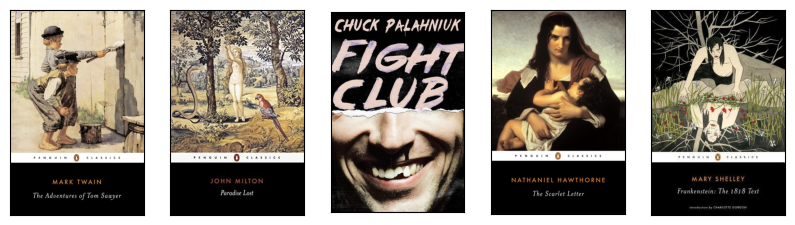

In [126]:
closest_cover(similar_covers, '24583.The_Adventures_of_Tom_Sawyer', 4)

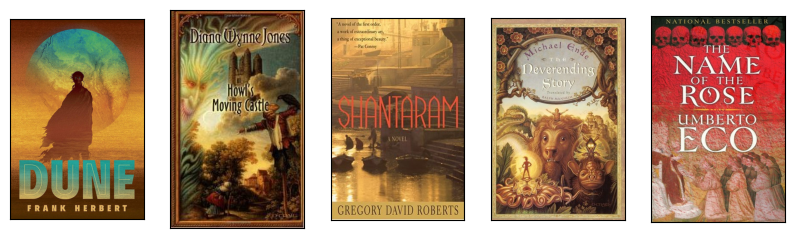

In [108]:
closest_cover(similar_covers, '44767458-dune', 4)

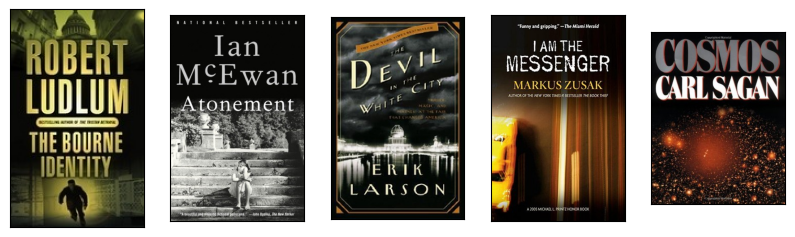

In [113]:
closest_cover(similar_covers, '7869.The_Bourne_Identity', 4)

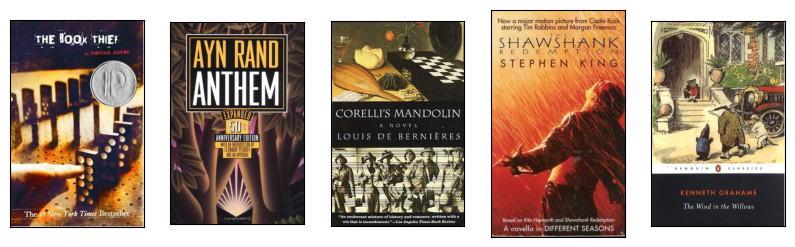

In [104]:
closest_cover(similar_covers, '19063.The_Book_Thief', 4)

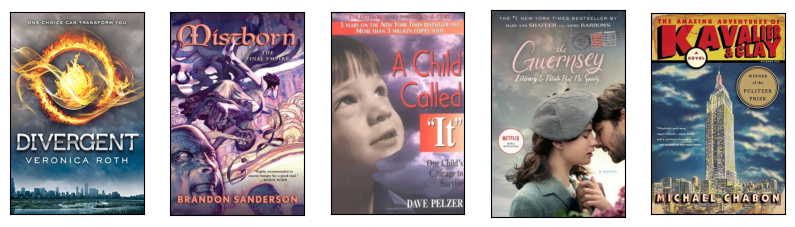

In [105]:
closest_cover(similar_covers, '13335037-divergent', 4)

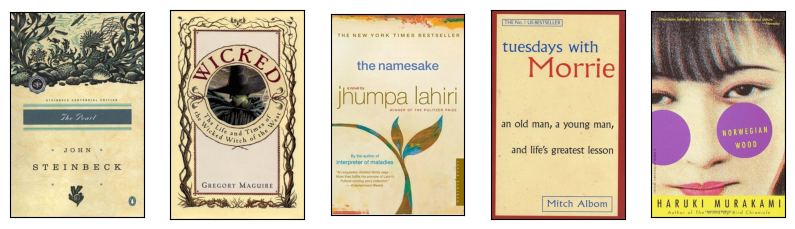

In [106]:
closest_cover(similar_covers, '5308.The_Pearl', 4)

Most of the times, the closest covers replicate the color palette and the patterns that can be found in the requested book cover.